In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb
import matplotlib.colors

N_episode = 300
FIGSIZE = (16,9)
colors = ['darkred', 'crimson', 'salmon', 'gold', 'lime', 
          'darkgreen', 'navy', 'royalblue', 'darkviolet', 'magenta'
         ]

LW = 5

In [2]:
def plot_performance(data, X=None, names=None, title="", ylabel="performance", 
                     minimum = -np.inf, maximum=np.inf, log=False, double=False, xlabel="learning episodes"):
    """
    data = [n_param, n_run, episode_length]
    """
    
    if names is None:
        names = [str(j) for j in range(len(data))]
    compute_X = (X is None)
    if len(data)<6:
        ncol = [1,1,2,2,3][len(data)-1] 
    else:
        ncol = len(data)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    handles = []
    for i in range(len(data)):
        if (double and i>=len(data)/2):
            linestyle = ":"
            color = colors[i%(len(data)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)        ]
        
        mean, std = np.mean(data[i], axis=0), np.std(data[i], axis=0)
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]

        for run in range(len(data[i])):
            plt.plot(X, data[i][run], color=color, lw=2, alpha=0.3, linestyle=linestyle)
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
       # ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
       # plt.plot(X, mean_p_std, color=color, alpha=0.2)
        #plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        #if (X[1]-X[0])!=(X[-1]-X[-2]):
        #    plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

In [3]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[ '' for _ in range(N-1)] for _ in range(N-1)]
    for (param1,param2) in pairs:
        data1 = np.array(data[param1])
        data2 = np.array(data[param2])
        stat, p_t = ttest_ind(data1,data2)
        p_t = p_t*coef
        d = truncate( np.mean(data1)-np.mean(data2), 2)
        if d=='0.00' or d=='-0.00':
            d = truncate( np.mean(data1)-np.mean(data2), 3)
            if d=='0.000' or d=='-0.000':
                d = truncate( np.mean(data1)-np.mean(data2), 4)
        if p_t < 0.001:
            res.append((param1, param2, '***'))
            cells[param1][N-1-param2] = d+'\n***'
        elif p_t < 0.01:
            res.append((param1, param2, '**'))
            cells[param1][N-1-param2] = d+'\n**'
        elif p_t < 0.05:
            res.append((param1, param2, '*'))
            cells[param1][N-1-param2] = d+'\n*'
        else:
            cells[param1][N-1-param2] = "ns"
    return res,cells

def plot_boxplot(data, names, ylabel="performance", ylim=None, title=""):
    N = len(data)
    stat,cells = compute_test(data, 3*N*(N-1)/2, N)
    
    plt.subplots(figsize=(12,10))
    
    bplot = sb.boxplot(data=data)
    for i in range(N):
        bplot.artists[i].set_facecolor(colors[i])
    sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
    
    rows = names[:N-1]
    columns = [names[i] for i in range(N-1,0,-1)]
    cell_text = cells
    cellColours = [['white' if N-1-i>j else 'lightgrey' for j in range(N-1)] for i in range(N-1) ]
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          cellColours= cellColours,
                          rowColours=colors[:N-1],
                          colColours=[ colors[i] for i in range(N-1,0,-1)],
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(1.13,0.1,0.5,0.9))
    
    plt.xticks(range(N), names)
    if not ylim is None:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)
        
def plot_z_rewards(subdirs, names, episodes=100):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations']
            if len(obs) == 1:
                obs = obs[0]
            rewards.append(np.array([o[-1, -1]<0.13 for o in obs]))
            if min_length > len(obs):
                min_length = len(obs)
        rewards = np.sum([reward[min_length-episodes:min_length]/(episodes) for reward in rewards], axis=1)
        Rewards.append(list(rewards))
    title="Average Percentage of fall of the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,1], ylabel="Percentage of fall", title=title)
    
def plot_model_training(subdirs, names):
    Train, Test = [], []
    for param in subdirs:
        trains, tests = [], []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            test = data['test_error']
            train = data['train_error']
            trains.append(np.mean(train,axis=1))
            tests.append(np.mean(test,axis=1))
            if min_length > len(test):
                min_length = len(test)
        tests = [ test[:min_length] for test in tests]
        trains = [ train[:min_length] for train in trains]
        Test.append(np.copy(tests))
        Train.append(np.copy(trains))
    Data = Train + Test
    Names = ["Training error "+x for x in names] + ["Testing error "+x for x in names]
    plot_performance(Data, names=Names, double=True, log=True, ylabel="Error", title="One Step Prediction Error")

In [4]:
Sizes = [
        [10, 10, 10], #0
        [50, 50, 50], #1
        [100, 100, 100], #2
        [200, 200, 200], #3
        [350, 350, 350], #4
        [500, 500, 500], #5 
        [750, 750, 750], #6
        [1000, 1000, 1000], #7
        [1000, 1000, 1000, 1000], #8
        [2000, 2000, 2000, 2000], #9 
]

N_params = []
for size in Sizes:
    N = 0
    N += 39 * size[0] + 1
    for i in range(len(size)-1):
        N += size[i] * size[i+1] + 1
    N += size[-1] * 31 + 1
    N_params.append(N)

Names = ['9e2', '8e3', '3e4', '9e4', '3e5', '5e5', '1e6', '2e6', '3e6', '1e7']

In [5]:
from data_log import *

In [6]:
names = Names

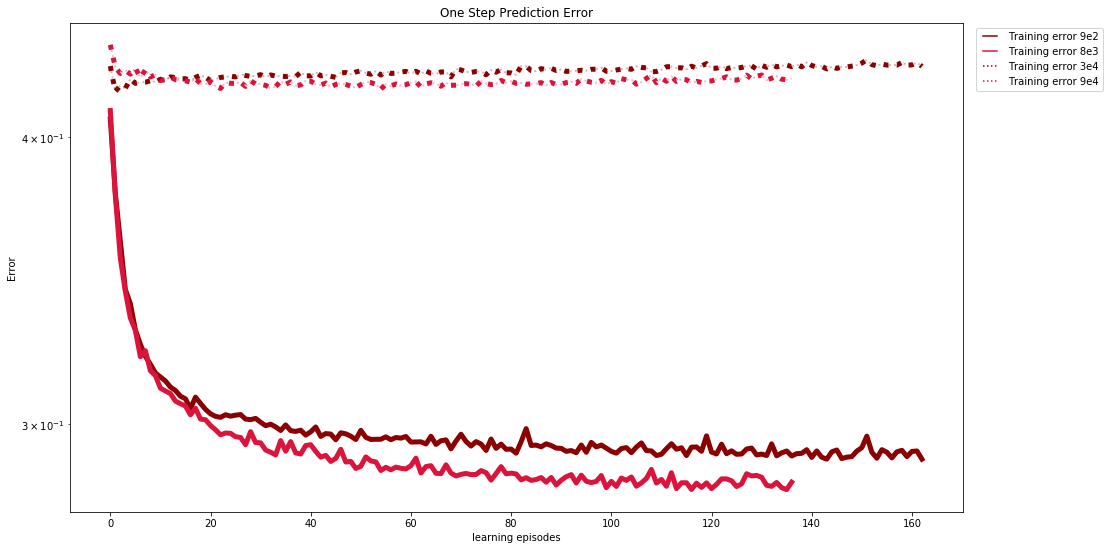

In [7]:
subdirs = np.array(contact_200)[[6,9]]

plot_model_training(subdirs[:], names[:])

In [36]:
folder = subdirs[1][0]
data = scipy.io.loadmat(folder)
test = data['test_error']
train = data['train_error']

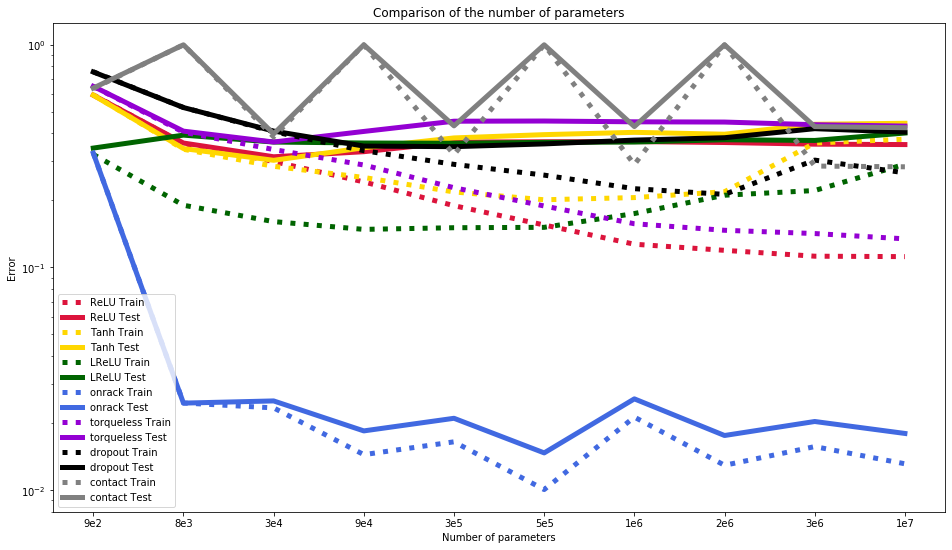

In [7]:
names = Names
k=1
f = [np.min, lambda x,y: x[-1, 0]/y][k]
plt.subplots(figsize=FIGSIZE)
j=0
colors = ['crimson','gold','darkgreen', 'royalblue', 'darkviolet', 'black', 'gray'
         ]
act = ['ReLU', 'Tanh', 'LReLU', 'onrack', 'torqueless', 'dropout', 'contact']
for subdirs in [ relu200, tan200, relu_suite_200, onrack200, torqueless200, dropout02_200, contact_200]:
    Train, Test = [], []
    for param in subdirs:
        trains, tests = [], []
        min_length = np.inf 
        for folder in param:
            try:
                data = scipy.io.loadmat(folder)
                test = data['test_error']
                train = data['train_error']
                c = np.sqrt(31) if j < 3 else 1
                trains.append(f(train,c))
                tests.append(f(test,c))
            except:
                tests.append(1)
                trains.append(1)

        Test.append(np.copy(tests))
        Train.append(np.copy(trains))
    plt.plot(Train, c=colors[j], lw=LW, ls=":", label=act[j]+" Train")
    plt.plot(Test, c=colors[j], lw=LW, ls="-", label=act[j]+" Test")
    j += 1

plt.title('Comparison of the number of parameters')
plt.ylabel('Error' if k else 'Min error' )
plt.xlabel('Number of parameters')
plt.yscale('log')
plt.xticks(range(len(Names)), Names)
plt.legend()

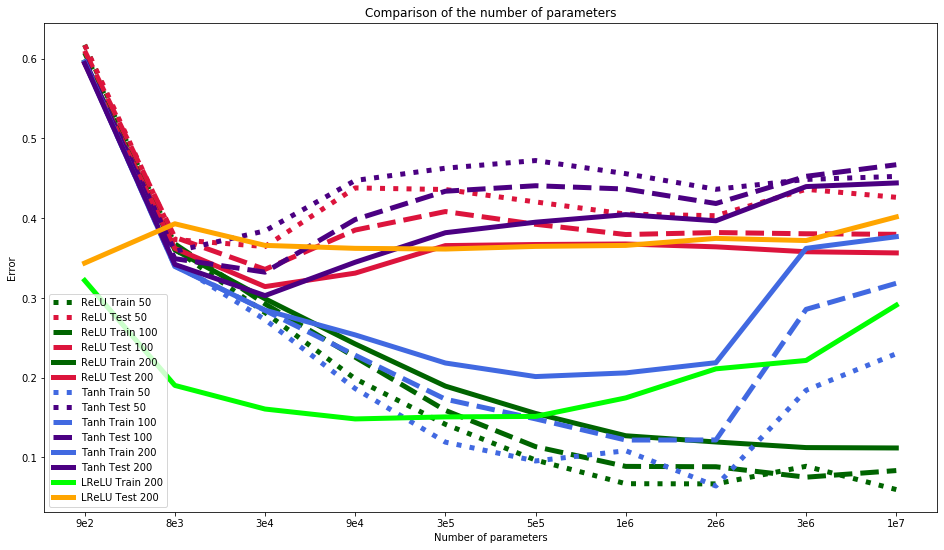

In [73]:
names = Names
k=1
f = [np.min, lambda x: x[-1, 0]/np.sqrt(31)][k]
plt.subplots(figsize=FIGSIZE)
j=0
colors1 = ['darkgreen', 'royalblue', 'lime']
colors2 = ['crimson', 'indigo', 'orange']
act = ['ReLU', 'Tanh', 'LReLU']
for activation in [[relu50, relu100, relu200], [tan50, tan100, tan200], [relu_suite_200]]:
    i = 0
    labels = ["50", "100", "200"]
    LS = [':', '--', '-']
    for subdirs in activation:
        Train, Test = [], []
        for param in subdirs:
            trains, tests = [], []
            min_length = np.inf 
            for folder in param:
                data = scipy.io.loadmat(folder)
                test = data['test_error']
                train = data['train_error']
                trains.append(f(train))
                tests.append(f(test))
            Test.append(np.copy(tests))
            Train.append(np.copy(trains))
        ls=LS[i] if j < 2 else "-"
        lab = labels[i] if j < 2 else "200"
        plt.plot(Train, c=colors1[j], lw=LW, ls=ls, label=act[j]+" Train "+lab)
        plt.plot(Test, c=colors2[j], lw=LW, ls=ls, label=act[j]+" Test "+lab)
        i += 1 
    j += 1

plt.title('Comparison of the number of parameters')
plt.ylabel('Error' if k else 'Min error' )
plt.xlabel('Number of parameters')
plt.xticks(range(len(Names)), Names)
plt.legend()

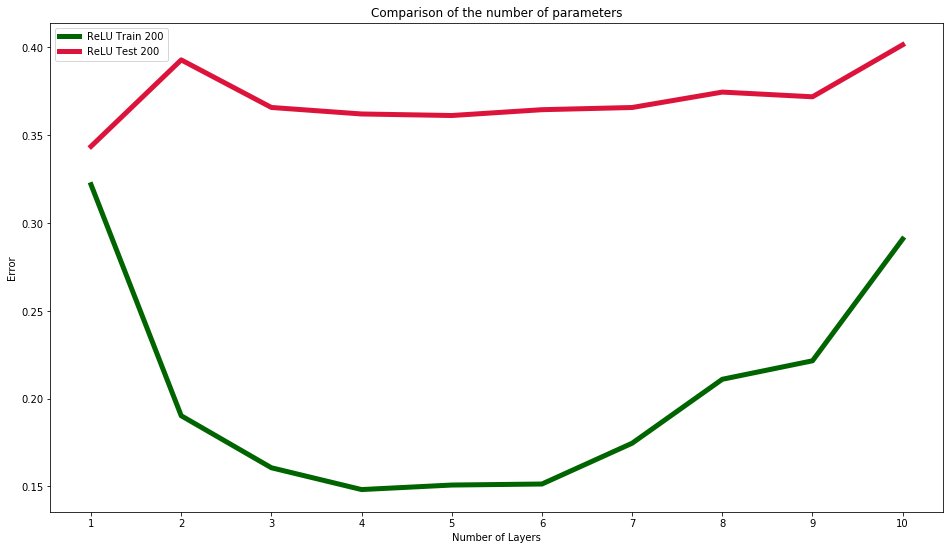

In [72]:
names = Names
k=1
f = [np.min, lambda x: x[-1, 0]/np.sqrt(31)][k]
plt.subplots(figsize=FIGSIZE)
j=0
act = ['ReLU']
for activation in [[relu_suite_200]]:
    i = 0
    labels = ["200"]
    LS = ['-']
    for subdirs in activation:
        Train, Test = [], []
        for param in subdirs:
            trains, tests = [], []
            min_length = np.inf 
            for folder in param:
                data = scipy.io.loadmat(folder)
                test = data['test_error']
                train = data['train_error']
                trains.append(f(train))
                tests.append(f(test))
            Test.append(np.copy(tests))
            Train.append(np.copy(trains))
        plt.plot(Train, c=['darkgreen', 'royalblue'][j], lw=LW, ls=LS[i], label=act[j]+" Train "+labels[i])
        plt.plot(Test, c=['crimson', 'indigo'][j], lw=LW, ls=LS[i], label=act[j]+" Test "+labels[i])
        i += 1 
    j += 1

plt.title('Comparison of the number of parameters')
plt.ylabel('Error' if k else 'Min error' )
plt.xlabel('Number of Layers')
plt.xticks(range(len(Names)), [str(i+1) for i in range(10)])
plt.legend()

In [207]:
path = './exp/log/Saved/model_size/'
folder = '2019-10-23--10:57:1025678'
file = path+folder+"/logs.mat"
data = scipy.io.loadmat(file)

In [209]:
with open("./data/train_eval_contact200.pk", 'rb') as f:
    training_in, training_out = pickle.load(f)
contact_in = training_in[:, 31:35]
contact_out = training_out[:, 31:]
change = []
not_change = []
for i in range(len(contact_in)):
    if np.sum(contact_in[i] == contact_out[i]) != 4:
        change.append(i)
    else:
        not_change.append(i)

In [23]:
with open("./data/train_eval_200.pk", 'rb') as f:
    training_in, training_out = pickle.load(f)

In [28]:
type(training_in)

numpy.ndarray

In [25]:
training_out.shape

(100000, 31)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5feeddfc50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5feecdd320>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5feecdd208>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5feee16ac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5feee16588>,
 'means': []}

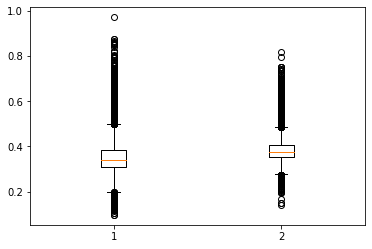

In [210]:
j = -1
all_error = data['all_training_error']
plt.boxplot([all_error[j,0, change],all_error[j,0, not_change]])

In [227]:
out_mean = np.mean(training_out, axis=0)
out_std = np.std(training_out, axis=0)
out_mean[31:] = 0
out_std[31:] = 1
target = (training_out-out_mean) / out_std
groups = [range(8), range(8,16), range(16,24), range(24,28), range(28,31), range(31,35)]

In [233]:
M, S = [], []
for i in range(3):
    pred = data['train_pred'][i]
    mean_error = (np.mean(abs(pred-target), axis=0))
    std_error = (np.std(abs(pred-target), axis=0))
    mean, std =  [], []
    for i in range(6):
        mean.append(np.mean(mean_error[groups[i]]))
        std.append(np.mean(std_error[groups[i]]))
    M.append(mean)
    S.append(std)

In [234]:
M

[[0.21461032165928834,
  0.1361882284457814,
  0.0852276216191453,
  0.48729613145522627,
  0.5373437286838809,
  0.6647225],
 [0.13085468521066435,
  0.08381722689166902,
  0.048804282306008875,
  0.3623258217028379,
  0.3958701120585045,
  0.6310925000000001],
 [0.1338833249569558,
  0.0829065128224791,
  0.0603880499439184,
  0.3428951418711929,
  0.3877221592549398,
  0.6331800000000001]]

In [258]:
with open('data/controller_72k.pk', 'rb') as f:
    samples = pickle.load(f)

In [259]:
R = samples['rewards']

In [265]:
obs = samples['obs']

In [278]:
best = []
good = []
not_bad = []
bad = []

In [279]:
count = 0
for i in range(len(R)):
    r = R[i]
    pos = obs[i][-1]
    if (r[4] == 0):
        if (r[0] > 1):
            if (-0.2<pos[29]<0.2):
                count += 1
                best.append(i)
            else:
                good.append(i)
        else:
            not_bad.append(i)
    else:
        bad.append(i) 
count

317

In [1]:
print(len(best), len(good), len(not_bad), len(bad))

NameError: name 'best' is not defined

In [300]:
train = best[:200]+good[:700]+not_bad[:9000]+bad[:5000]
eval = best[200:]+good[700:]+not_bad[9000:]+bad[5000:6000]

In [ ]:
t-sne

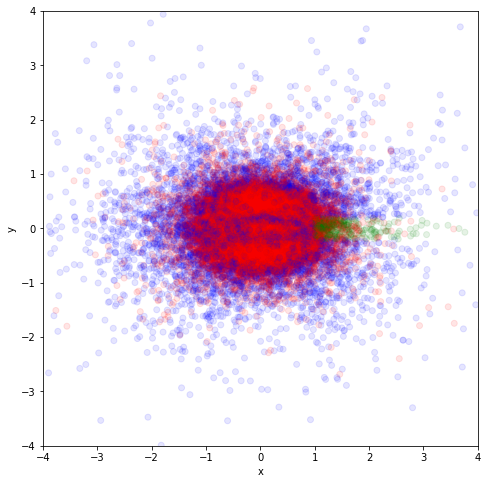

In [281]:
N = len(R)
Pos = []
color = ['b'] * N
for i in range(N):
    pos = obs[i][-1]
    Pos.append(pos)
    if R[i][-1] != 0:
        color[i] = 'r'
    if (R[i][0] > 1) and (R[i][4] == 0) and (-0.2<pos[29]<0.2):
        color[i] = 'g'
        
Pos = np.array(Pos)
plt.subplots(figsize=(8,8))
plt.scatter(Pos[:, 28], Pos[:, 29], color=color, alpha=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)317
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("y")
plt.xlabel("x");

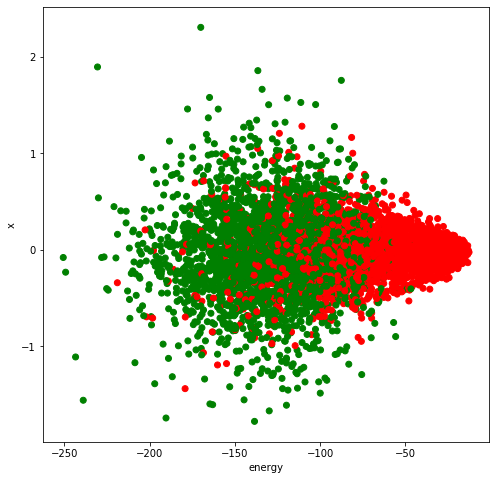

In [210]:
color = ['g'] * N
for i in range(N):
    if R[i,-1] != 0:
        color[i] = 'r'


plt.subplots(figsize=(8,8))
plt.scatter(R[:, 1], R[:, 0], color=color)
plt.ylabel("x")
plt.xlabel("energy");

In [126]:
import numpy as np
from sklearn.decomposition import PCA
R = R.reshape(-1,1)
X = np.concatenate((np.array(params)/np.std(params,axis=0), R),axis=1)
pca = PCA(n_components=2)
y = pca.fit_transform(X)  

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)
print(pca.components_ )

[0.06870701 0.06323544]
[134.78642478 129.30814989]
[[ 0.05211234 -0.10029913  0.11674771 -0.05188264  0.10270006  0.23580786
   0.25307168  0.34849113  0.18948542  0.31172815  0.16500091  0.22849829
  -0.353669   -0.14262035 -0.22641722 -0.36846653 -0.4174781 ]
 [-0.26771564  0.33819652 -0.30917081 -0.00144432  0.21550205  0.37836822
  -0.32364803  0.41203595  0.03633618  0.08077357 -0.0069446  -0.42505206
  -0.07867803 -0.13275308  0.19352006  0.0663302   0.00345986]]


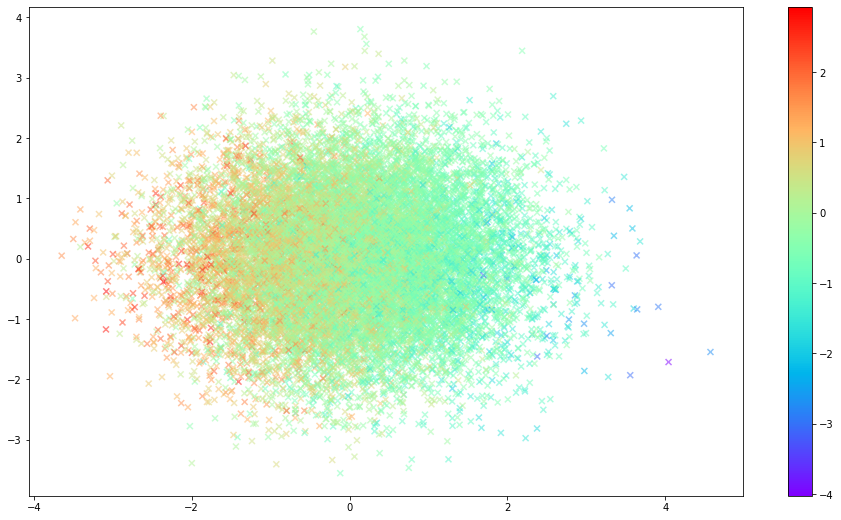

In [132]:
y = y
i, j = 0, 1
fig, ax = plt.subplots(figsize=FIGSIZE)
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=min(R), vmax=max(R))
color=cmap(norm(R))
plt.scatter(y[:,i], y[:,j], marker='x',c=color, alpha=0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm);

/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


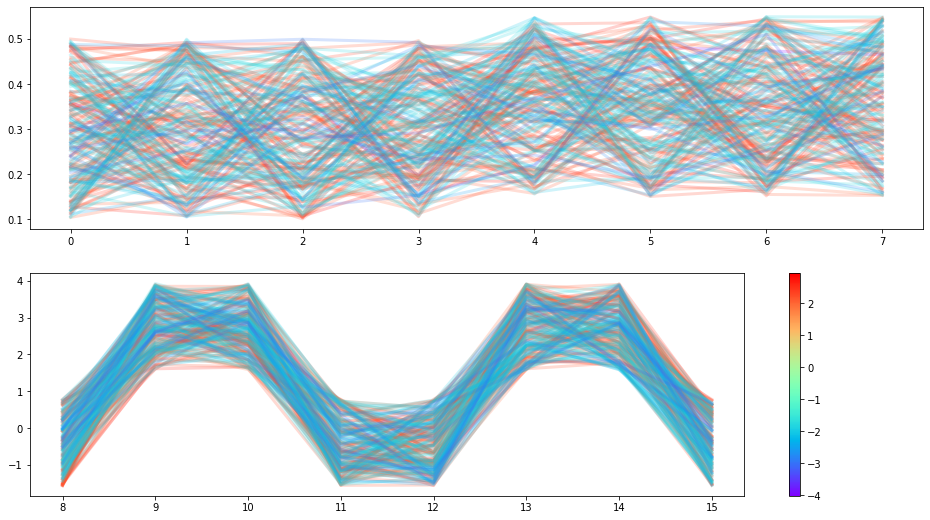

In [72]:
controller_params = params
index = np.argsort(R)
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=min(R), vmax=max(R))
colors=cmap(norm(R))

fig, ax = plt.subplots(2,figsize=FIGSIZE)
All = 0
for j in list(range(100))+list(range(-100,0)):
    sols = controller_params[j]
    j = index[-j]
    r = R[j]
    color, alpha, lw = colors[j], 0.2, 3
    plt.subplot(211)
    plt.plot(sols[:8], alpha=alpha, lw=lw, color=color)
    plt.subplot(212)
    plt.plot(sols[8:], alpha=alpha, lw=lw, color=color)
plt.xticks(range(8),[str(i) for i in range(8, 16)]);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm);

In [133]:
i = index[-1]
print(R[i])
params[i]

2.931241701311425


array([ 0.15196979,  0.44120215,  0.44734516,  0.4737556 ,  0.4331324 ,
        0.39177511,  0.32945941,  0.19081727, -0.9101725 ,  1.9585776 ,
        2.91960988,  0.21910417,  0.59179691,  3.30090196,  2.63766518,
        0.54396721])

In [134]:
x = np.array([ 0.15196979,  0.44120215,  0.44734516,  0.4737556 ,  0.4331324 ,
        0.39177511,  0.32945941,  0.19081727, -0.9101725 ,  1.9585776 ,
        2.91960988,  0.21910417,  0.59179691,  3.30090196,  2.63766518,
        0.54396721])

In [248]:
(1.6 % 0.5)*2

0.20000000000000018

In [250]:
a = np.random.random(8)
a

array([0.83944337, 0.6673004 , 0.1158674 , 0.42245789, 0.31805082,
       0.5690043 , 0.10912957, 0.68343818])

In [253]:
a[np.array([1,2,3])]

array([0.6673004 , 0.1158674 , 0.42245789])